In [11]:
# --- Standard libraries
import os
import re
import json
import codecs
import pickle as pkl
import numpy as np
import pandas as pd
from tqdm import tqdm
from natsort import natsorted
# --- Matplotlib
import matplotlib.pyplot as plt
# --- ASE
from ase.io import read
# --- RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolFromXYZFile
from rdkit.Chem import rdDetermineBonds
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
rdkit.__version__

'2024.03.5'

### Code functions

In [44]:
def get_xyz_file(directory):
    '''
    Find the file path of the optimized geometry file
    in a given directory
    '''
    # Get a list of all the files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    # Pattern to find the xyz file
    pattern = r'OPT_[\w]+\.xyz$'
    # Search for the file from pattern
    for file in files:
        if re.match(pattern, file):
            xyz_name = file
            break

    xyz_path = os.path.join(directory, xyz_name)
    return xyz_path

def rearrange_xyz(file_path):
    '''
    Function that rearranges the given .xyz file to move all the
    oxygen and hydrogen atoms to the bottom of the file
    '''
    # Open the original .xyz file and parse the lines with
    # O and H coordinates to lists
    with open(file_path, 'r') as fr:
        lines = fr.readlines()
        o_lines = []
        h_lines = []

        for line in lines:
            if line.startswith('  O'):
                o_lines.append(line)
            elif line.startswith('  H'):
                h_lines.append(line)

        # Open the .xyz file to write
        with open(file_path, 'w') as fw:

            # Write all lines that are not O or H coordinates
            for line in lines:
                if line.startswith('  H'):
                    pass
                elif line.startswith('  O'):
                    pass
                else:
                    fw.write(line)
        
            # Write O coordinates
            for x in o_lines:
                fw.write(x)
            # Write H coordinates
            for y in h_lines:
                fw.write(y)

def analyse_mol(file_path):
    '''
    Take in an XYZ file and extract information: smiles string,
        atom indexes, coordinates, and atomic numbers
    '''
    # Read in and create RDkit mol variable
    mol = MolFromXYZFile(file_path)
    rdDetermineBonds.DetermineBonds(mol)
    Chem.RemoveStereochemistry(mol)
    
    # Get the xyz coordinates of the molecule
    atoms = read(file_path)
    pos = atoms.get_positions()
    z = atoms.get_atomic_numbers()

    # Count the number of carbons in molecule
    num_carbons = np.count_nonzero(z == 6)
    # Create empty array to fill in with atom idxs
    indexes = np.empty([num_carbons, 2])
    # Fill idx array in numerical order
    for x in range(num_carbons):
        indexes[x, :] = x

    # # Set the xyz atom indexing as rdkit map numbers
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetAtomMapNum(atom.GetIdx())

    # Reload the mol to get the rdkit/networkx atom idx
    smiles = Chem.MolToSmiles(mol)
    new_mol = Chem.MolFromSmiles(smiles)
    # Add the rdkit/networkx index to the corresponding
    # xyz index value in the array
    for atom in new_mol.GetAtoms():
        if atom.GetAtomicNum() == 6:
            indexes[atom.GetAtomMapNum(), 1] = atom.GetIdx()

    return atoms, smiles, indexes, pos, z

def broaden_spectrum(E, osc):
    '''
    Take the delta peaks of a XAS spectrum and applies
    a Voigt broadening scheme
    '''

    x = np.linspace(280, 300, num=200, endpoint=True)
    sigma = 0.5
    mix = 0.5
    gE = []

    # Apply Voigt broadening
    for Ei in x:
        tot = 0
        for Ej, os in zip(E, osc):
             tot += os * (((1 - mix) * (np.exp(- np.log(2) * ((((Ej - Ei) / sigma) ** 2))))) + (mix *((1 + ((((Ej - Ei) / sigma) ** 2))) ** - 1)) )
        gE.append(tot)
    
    return gE

def broaden_gaussian(E, osc, sigma, x):
    '''
    Take the delta peaks of a XAS spectrum and applies
    a Gaussian broadening scheme
    '''
    gE = []

    # Apply Gaussian broadening
    for Ei in x:
        tot = 0
        for Ej, os in zip(E, osc):
            tot += os * (np.exp(-np.log(2) * ((((Ej - Ei) / sigma) ** 2))))
        gE.append(tot)
    
    return gE

def broaden_lorentzian(E, osc, sigma, x):
    '''
    Take the delta peaks of a XAS spectrum and applies
    a Lorentzian broadening scheme
    '''
    gE = []

    # Apply Gaussian broadening
    for Ei in x:
        tot = 0
        for Ej, os in zip(E, osc):
            tot += os * ((1 + ((((Ej - Ei) / sigma) ** 2))) ** - 1)
        gE.append(tot)
    
    return gE

### Start code

In [45]:
# Path to main folder where all the data is
data_path = '../../work/data/GO_XAS_data/old/coronene/'
# Create a list with the path of all the different molecule folders
subdirs = [os.path.join(data_path, d) for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# Number of molecules in the data set
print(len(subdirs))
# List of paths to all the different molecules
print(subdirs)

318
['../../work/data/GO_XAS_data/old/coronene/R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_1_1', '../../work/data/GO_XAS_data/old/coronene/R_eOH_3_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_0_1', '../../work/data/GO_XAS_data/old/coronene/R_eOH_2_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_2', '../../work/data/GO_XAS_data/old/coronene/R_eOH_2_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_0_2', '../../work/data/GO_XAS_data/old/coronene/R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_2_iOH_0_iEPOXY_1_ieEPOXY_0_1', '../../work/data/GO_XAS_data/old/coronene/R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_4_0', '../../work/data/GO_XAS_data/old/coronene/R_eOH_1_eCOOH__1_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_0_0', '../../work/data/GO_XAS_data/old/coronene/R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_2_iOH_0_iEPOXY_0_ieEPOXY_0_2', '../../work/data/GO_XAS_data/old/coronene/R_eOH_1_eCOOH__1_eEPOXY_1_eCHO_1_eKETO_0_iOH_0_iEPOXY_0_i

In [46]:
mol_name = []
# Split up into the directory path and list of all the folder/molecule names
for subdir in subdirs:
    dir_path, path = os.path.split(subdir)
    mol_name.append(path)

print(len(mol_name))
# List of all the molecule names
print(mol_name)

318
['R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_2_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_1_1', 'R_eOH_3_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_0_1', 'R_eOH_2_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_2', 'R_eOH_2_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_0_2', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_2_iOH_0_iEPOXY_1_ieEPOXY_0_1', 'R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_4_0', 'R_eOH_1_eCOOH__1_eEPOXY_1_eCHO_0_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_0_0', 'R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_2_iOH_0_iEPOXY_0_ieEPOXY_0_2', 'R_eOH_1_eCOOH__1_eEPOXY_1_eCHO_1_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_0', 'R_eOH_1_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_0_0', 'R_eOH_1_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_2_ieEPOXY_0_1', 'R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_1_eKETO_0_iOH_2_iEPOXY_0_ieEPOXY_0_2', 'R_eOH_1_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_2_1', 'R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_2_iOH_0_iEPOXY_1_ieEPOXY_0_2', '

In [47]:
# Create python dictionaries

df = pd.DataFrame(columns=['SMILES', 'ASE atoms', 'Spectrum'])

# Loop through all the molecule directories
for subdir in tqdm(subdirs):
    dir_path, mol_name = os.path.split(subdir)

    # Get the pathof the xyz file
    xyz_path = get_xyz_file(subdir)
    # Rearrage the xyz file 
    rearrange_xyz(xyz_path)
    # Get the smiles string of mol along with
    # the two different indexes of xyz and rdkit
    atoms, smiles, indexes, pos, z = analyse_mol(xyz_path)

    # Get all the individual atom directories for molecule
    atom_direcs = [os.path.join(subdir, d) for d in os.listdir(subdir) if os.path.isdir(os.path.join(subdir, d))]
    # Sort directories in numerical order
    sorted_direcs = natsorted(atom_direcs)
    spec_dict = {}

    # 
    for i in range(len(sorted_direcs)):
        atom_dir = sorted_direcs[i]
        # Get a list of all the files in the directory
        atom_files = [f for f in os.listdir(atom_dir) if os.path.isfile(os.path.join(atom_dir, f))]

        # 
        for file in atom_files:
            if file.endswith('abs.stk'):
                spec_df = pd.read_csv(os.path.join(atom_dir, file), sep='\s+', header=None,
                                      names=['Peaks', 'Strength'])
                # Extract the photon energy and oscilator strength
                energies, osc = spec_df['Peaks'], spec_df['Strength']
                # Broaden the spectra
                gE = broaden_spectrum(energies, osc)

                # Save as rdkit/networkx indexing
                spec_dict[int(indexes[i, 1])] = gE

    # Sum up all atom spectra to total mol spectrum
    tot_spec = np.zeros(200)
    for key in spec_dict.keys():
        tot_spec += spec_dict[key]            

    df = pd.concat([df, pd.DataFrame([[smiles, atoms, tot_spec]], columns=['SMILES', 'ASE atoms', 'Spectrum'])], ignore_index=True)


100%|██████████| 318/318 [05:00<00:00,  1.06it/s]


In [48]:
df

,SMILES,ASE atoms,Spectrum
0,c12[c:2]3[c:1]([H:39])[c:23]([O:26][H:37])[c:2...,"(Atom('C', [np.float64(0.12075861228129), np.f...","[694.2256529897921, 721.0846150985162, 750.004..."
1,c12[c:2]3[c:1]([O:26][H:37])[c:24]([H:44])[c:2...,"(Atom('C', [np.float64(-0.05111715022858), np....","[731.6084273164089, 761.9674028451632, 794.862..."
2,c12[c:4]3[c:8]4[c:12]5[c:14]6[c:15]([H:34])[c:...,"(Atom('C', [np.float64(0.06557402770504), np.f...","[544.7428966052354, 561.4694685081686, 579.129..."
3,C123[C:2]4([H:39])[C:1](=[O:24])[C:23]([H:36])...,"(Atom('C', [np.float64(0.02673797317953), np.f...","[567.4086321235976, 585.7382464360214, 605.162..."
4,C123[C:2]4=[C:1]([H:29])[C:25]([H:32])=[c:24]5...,"(Atom('C', [np.float64(-0.03793796557564), np....","[723.5094617712231, 751.377106320992, 781.2890..."
...,...,...,...
313,c12[c:2]3[c:1]([H:30])[c:24]([H:34])[c:23]4[c:...,"(Atom('C', [np.float64(-0.03821846521075), np....","[728.9008001099027, 758.0781126771527, 789.428..."
314,c12[c:2]3[c:1]([H:29])[c:23]([H:37])[c:22]4[c:...,"(Atom('C', [np.float64(-0.05389698406581), np....","[493.9654782777706, 507.4897805773835, 521.683..."
315,c12[c:4]3[c:8]4[c:12]5[c:16]6[c:18]7[c:19]([H:...,"(Atom('C', [np.float64(-0.02127832300276), np....","[591.7650998649364, 612.5791286251117, 634.912..."
316,c12[c:2]3[c:3]([H:31])[c:5]([H:32])[c:6]4[c:4]...,"(Atom('C', [np.float64(0.02121358808133), np.f...","[651.5345752869929, 675.1954056279167, 700.475..."


In [49]:
df.to_pickle('./raw/data_coronene_voigt.pkl')

### Check saved data

In [50]:
data_file = open('./raw/data_coronene_voigt.pkl', 'rb')
data = pkl.load(data_file)

In [51]:
data

,SMILES,ASE atoms,Spectrum
0,c12[c:2]3[c:1]([H:39])[c:23]([O:26][H:37])[c:2...,"(Atom('C', [np.float64(0.12075861228129), np.f...","[694.2256529897921, 721.0846150985162, 750.004..."
1,c12[c:2]3[c:1]([O:26][H:37])[c:24]([H:44])[c:2...,"(Atom('C', [np.float64(-0.05111715022858), np....","[731.6084273164089, 761.9674028451632, 794.862..."
2,c12[c:4]3[c:8]4[c:12]5[c:14]6[c:15]([H:34])[c:...,"(Atom('C', [np.float64(0.06557402770504), np.f...","[544.7428966052354, 561.4694685081686, 579.129..."
3,C123[C:2]4([H:39])[C:1](=[O:24])[C:23]([H:36])...,"(Atom('C', [np.float64(0.02673797317953), np.f...","[567.4086321235976, 585.7382464360214, 605.162..."
4,C123[C:2]4=[C:1]([H:29])[C:25]([H:32])=[c:24]5...,"(Atom('C', [np.float64(-0.03793796557564), np....","[723.5094617712231, 751.377106320992, 781.2890..."
...,...,...,...
313,c12[c:2]3[c:1]([H:30])[c:24]([H:34])[c:23]4[c:...,"(Atom('C', [np.float64(-0.03821846521075), np....","[728.9008001099027, 758.0781126771527, 789.428..."
314,c12[c:2]3[c:1]([H:29])[c:23]([H:37])[c:22]4[c:...,"(Atom('C', [np.float64(-0.05389698406581), np....","[493.9654782777706, 507.4897805773835, 521.683..."
315,c12[c:4]3[c:8]4[c:12]5[c:16]6[c:18]7[c:19]([H:...,"(Atom('C', [np.float64(-0.02127832300276), np....","[591.7650998649364, 612.5791286251117, 634.912..."
316,c12[c:2]3[c:3]([H:31])[c:5]([H:32])[c:6]4[c:4]...,"(Atom('C', [np.float64(0.02121358808133), np.f...","[651.5345752869929, 675.1954056279167, 700.475..."


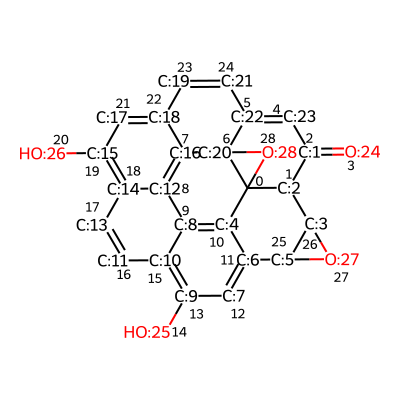

In [52]:
# Create RDKit mol from SMILES
mol = Chem.MolFromSmiles(data.iloc[3]['SMILES'])
mol

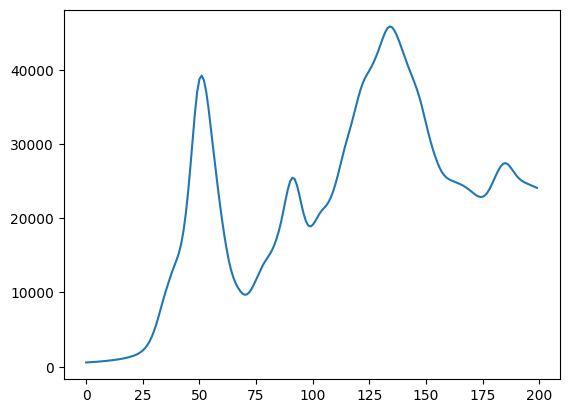

In [55]:
# Plot spectra
plt.plot(data.iloc[3]['Spectrum'])
plt.show()